In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow import keras

In [2]:
df = pd.read_csv('loan_data.csv')

In [3]:
x = df.drop(columns='credit.policy')
y = df['credit.policy']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


# Exploratory data analysis

In [5]:
df.isna().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

there is no missing data

<AxesSubplot:xlabel='credit.policy', ylabel='count'>

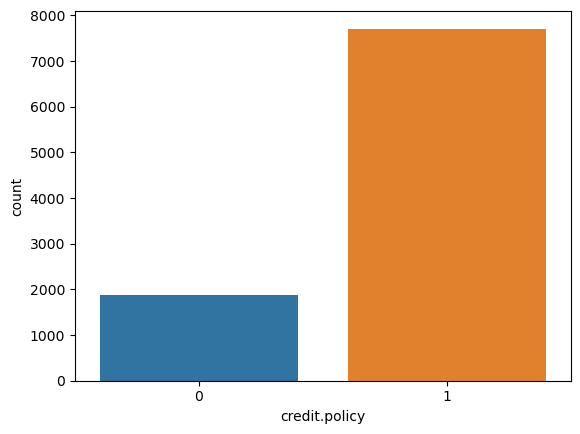

In [6]:
sns.countplot(data=df, x='credit.policy')

credit policy is imbalanced

In [7]:
df.purpose.unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

there are 7 unique values for purpose

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [9]:
x_train.corr()

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
int.rate,1.000000,0.282487,0.057133,0.232004,-0.713742,-0.125724,0.089990,0.449967,0.198629,0.160884,0.096089,0.151139
installment,0.282487,1.000000,0.440888,0.040861,0.085486,0.167500,0.219224,0.070401,-0.015426,0.000247,-0.035824,0.050435
log.annual.inc,0.057133,0.440888,1.000000,-0.059310,0.107517,0.321403,0.379186,0.053099,0.024022,0.032332,0.010110,-0.029102
dti,0.232004,0.040861,-0.059310,1.000000,-0.258317,0.051534,0.194612,0.338452,0.030909,-0.018808,0.007735,0.044973
fico,-0.713742,0.085486,0.107517,-0.258317,1.000000,0.258669,-0.024663,-0.543382,-0.178679,-0.217709,-0.147610,-0.142722
days.with.cr.line,-0.125724,0.167500,0.321403,0.051534,0.258669,1.000000,0.233590,-0.027845,-0.048534,0.087398,0.063644,-0.026647
revol.bal,0.089990,0.219224,0.379186,0.194612,-0.024663,0.233590,1.000000,0.213762,0.023657,-0.029076,-0.034576,0.054097
revol.util,0.449967,0.070401,0.053099,0.338452,-0.543382,-0.027845,0.213762,1.000000,-0.014780,-0.038607,0.059439,0.075493
inq.last.6mths,0.198629,-0.015426,0.024022,0.030909,-0.178679,-0.048534,0.023657,-0.014780,1.000000,0.005131,0.064685,0.150606
delinq.2yrs,0.160884,0.000247,0.032332,-0.018808,-0.217709,0.087398,-0.029076,-0.038607,0.005131,1.000000,0.012423,-0.001562


<AxesSubplot:>

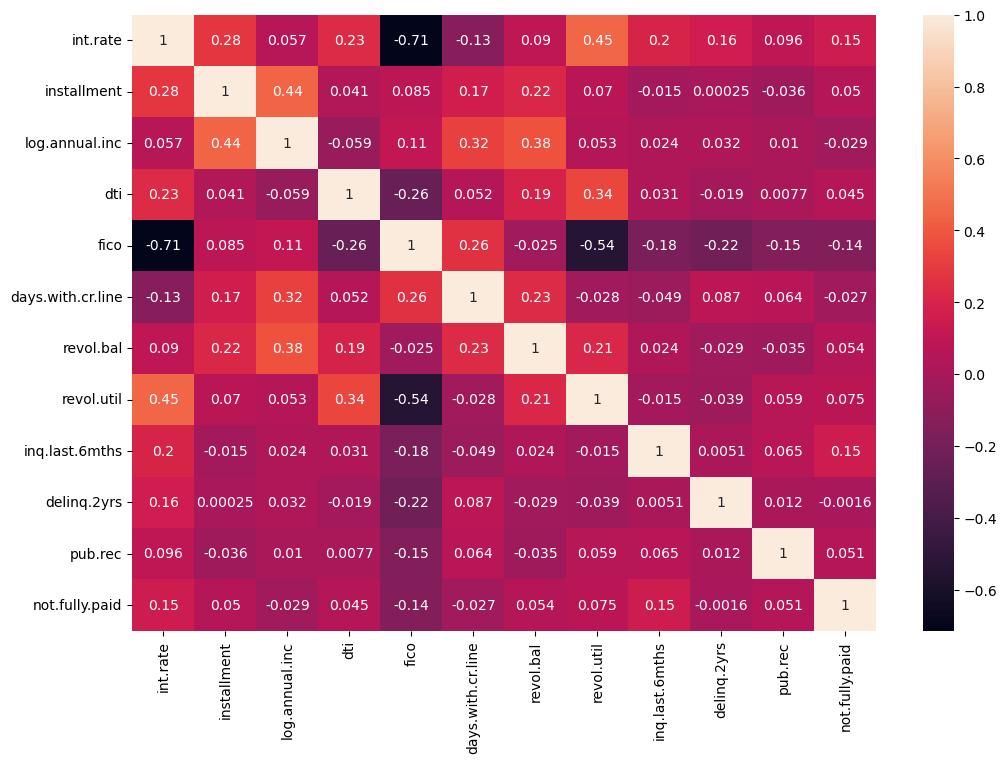

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(x_train.corr(), annot=True)

# find high correlated columns

In [11]:
def find_corr(data, threshold):
    corr_df = data.corr()
    result = []

    for i, col in enumerate(corr_df.columns):
        # only search under the diagonal
        series = corr_df[col][i + 1:]

        # find cols above the correlation threshold
        high_corr = series[series > threshold]

        result.extend(high_corr.index.tolist())

    return result


high_corr_cols = find_corr(x_train, 0.4)
high_corr_cols

['revol.util', 'log.annual.inc']

revol.util is positively correlated with int.rate
log.annual.inc is positively correlated with installment

revol.util and log.annual.inc will be dropped

## separate categorical and numerical columns

In [12]:
cat_cols = x_train.select_dtypes(include='object').columns
cat_cols

Index(['purpose'], dtype='object')

In [13]:
num_cols = x_train.select_dtypes(include='number').columns
num_cols

Index(['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
       'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths',
       'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

## drop features with high correlation

In [14]:
num_cols = list(set(num_cols) - set(high_corr_cols))
num_cols

['int.rate',
 'installment',
 'delinq.2yrs',
 'days.with.cr.line',
 'inq.last.6mths',
 'dti',
 'revol.bal',
 'not.fully.paid',
 'pub.rec',
 'fico']

## set up data preprocessing pipeline

In [15]:
numerical_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Modeling

In [16]:
model = keras.Sequential()
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
model.fit(preprocessor.fit_transform(x_train), y_train)

210/210 [==============================] - 1s 1ms/step - loss: 0.3586 - accuracy: 0.8541


In [18]:
model.evaluate(preprocessor.transform(x_test), y_test)

90/90 [==============================] - 0s 775us/step - loss: 0.2830 - accuracy: 0.8838


[0.28302687406539917, 0.8837856650352478]